In [9]:
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.applications.inception_v3 import preprocess_input
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base_image_dir = os.path.join('/home/jupyter/tensorflow_datasets/downloads/')

retina_df = pd.read_csv(os.path.join(base_image_dir, 'labels', 'testLabels15.csv'))
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,'resized_test_15',
                                                         '{}.jpg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']].drop_duplicates()
retina_df['diagnosis'] = retina_df['level'].map(lambda x: str(x))


53576 images found of 53576 total


In [3]:
config = tf.compat.v1.ConfigProto(gpu_options =
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)


In [5]:
# Preprocessing functions

def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0),sigmaX),-4 ,128)
        
    return preprocess_input(image)


def auto_crop(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        return preprocess_input(img)

In [11]:
batch_size = 32
IMG_SIZE = 512


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0, 
    horizontal_flip=False,
    vertical_flip=False, 
    # preprocess_input for no other preprocessing method; 
    # load_ben_color for graham pre-process;
    # auto_crop for auto cropping the image;
    preprocessing_function=preprocess_input,
    data_format="channels_last")

test_generator = test_datagen.flow_from_dataframe(retina_df, 
                                                  x_col='path', 
                                                  y_col='diagnosis',
                                                  target_size=(IMG_SIZE,IMG_SIZE),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 53576 validated image filenames belonging to 5 classes.


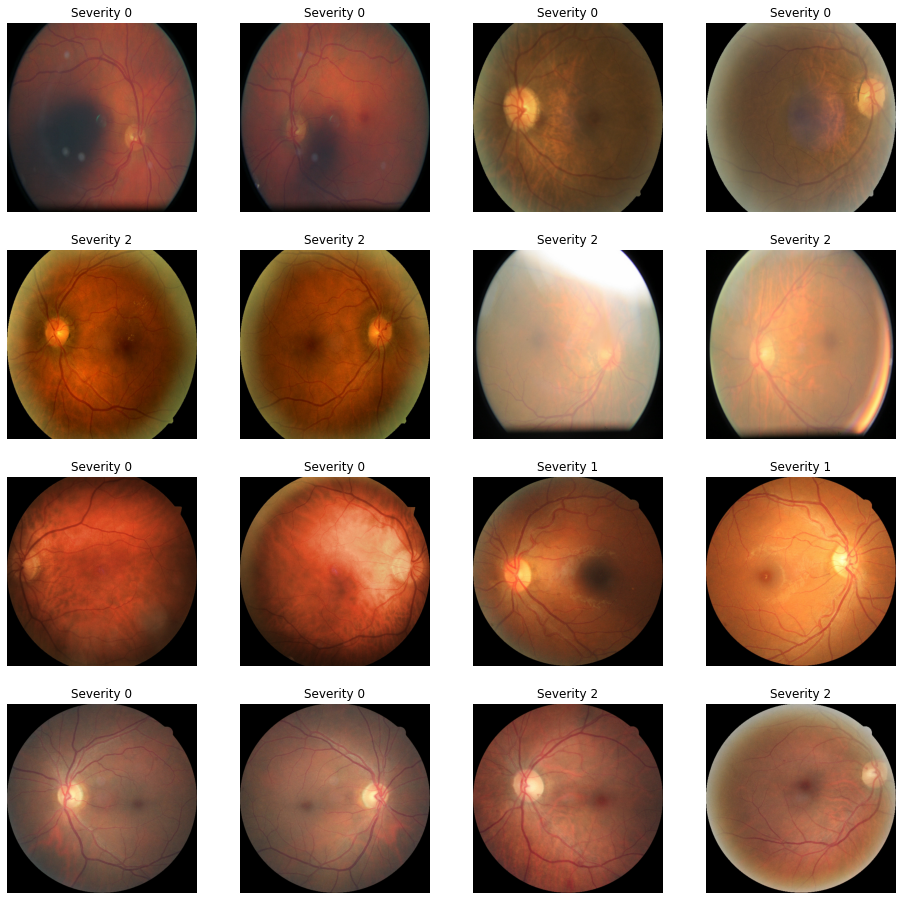

In [12]:
t_x, t_y = next(test_generator)
input_shape=t_x.shape[1:]
num_classes=t_y.shape[1]

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')
#     print(c_x.dtype)
plt.show()


In [4]:
# load the target model and weights

# change 'my_model' name to the target model
my_model = 'xception_autocrop'


model_name = my_model+'_retina_model.h5'
model_weights = my_model+'_weights_best.hdf5'

def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

new_model = tf.keras.models.load_model(model_name,
                                       custom_objects = {'top_2_accuracy': top_2_accuracy})

new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                

In [6]:

new_model.compile(optimizer = 'adam', 
                  loss = 'categorical_crossentropy',
                  metrics = ['categorical_accuracy', top_2_accuracy])

new_model.load_weights(model_weights)

new_model.evaluate(test_generator,
                   verbose=1,
                   workers=8)


Found 53576 validated image filenames belonging to 5 classes.
1675/1675 [==============================] - 2036s 1s/step - loss: 4.5536 - categorical_accuracy: 0.7037 - top_2_accuracy: 0.8372


[4.553624153137207, 0.7036919593811035, 0.837165892124176]